# TSA checks


# Imports

In [4]:
import sys
sys.path.append('../')

import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, pacf

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
%matplotlib inline


from src.fetch_data import DataLoader
from src.processing import FeatureEngineering


feature_engineering = FeatureEngineering()


# Getting the data

In [3]:
# Then load the raw sales data
data_path = 'data/merged/train.csv'
version = 'merged_v3'
repo = '../'

train_df = DataLoader.dvc_get_data(data_path, version, repo)
train_df['Date'] = pd.to_datetime(train_df['Date'])


/home/hat/dev-env/10Acadamy/week_3/Rossmann-Pharmaceuticals-Sales-Forcast/notebooks/../src/fetch_data.py:28: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(content), sep=",")
DataLoaderLogger - INFO - DVC: CSV file read with path: data/merged/train.csv | version: merged_v3 | from: ../


I will add the additional columns from the feature engineering here

In [5]:
train_df = feature_engineering.transform(train_df)


PreProcessorLogger - INFO - 9 new columns added to the dataframe
PreProcessorLogger - INFO - Feature enginerring completed


In order to properly split the data, we need the timeframe for it. I will grab all the unique dates in the `Date` column

In [6]:
timeframe = train_df.Date.unique()
timeframe.sort()
print(f"Starts at {timeframe[0]} --- ends at: {timeframe[-1]}")
print(f"It spans for {len(timeframe)} days")

Starts at 2013-01-01T00:00:00.000000000 --- ends at: 2015-07-31T00:00:00.000000000
It spans for 942 days


# EDA for modeling (with a sampled store)

Let's pick one of the stores and plot their sales for year 

In [7]:
sample_store = train_df.query("Store==1000 & Year==2014")
sample_store = sample_store.sort_values(by='Date', ascending=False)
sample_store.shape

(181, 29)

Text(0.5, 1.0, 'Sales of 2014 for Store 1000')

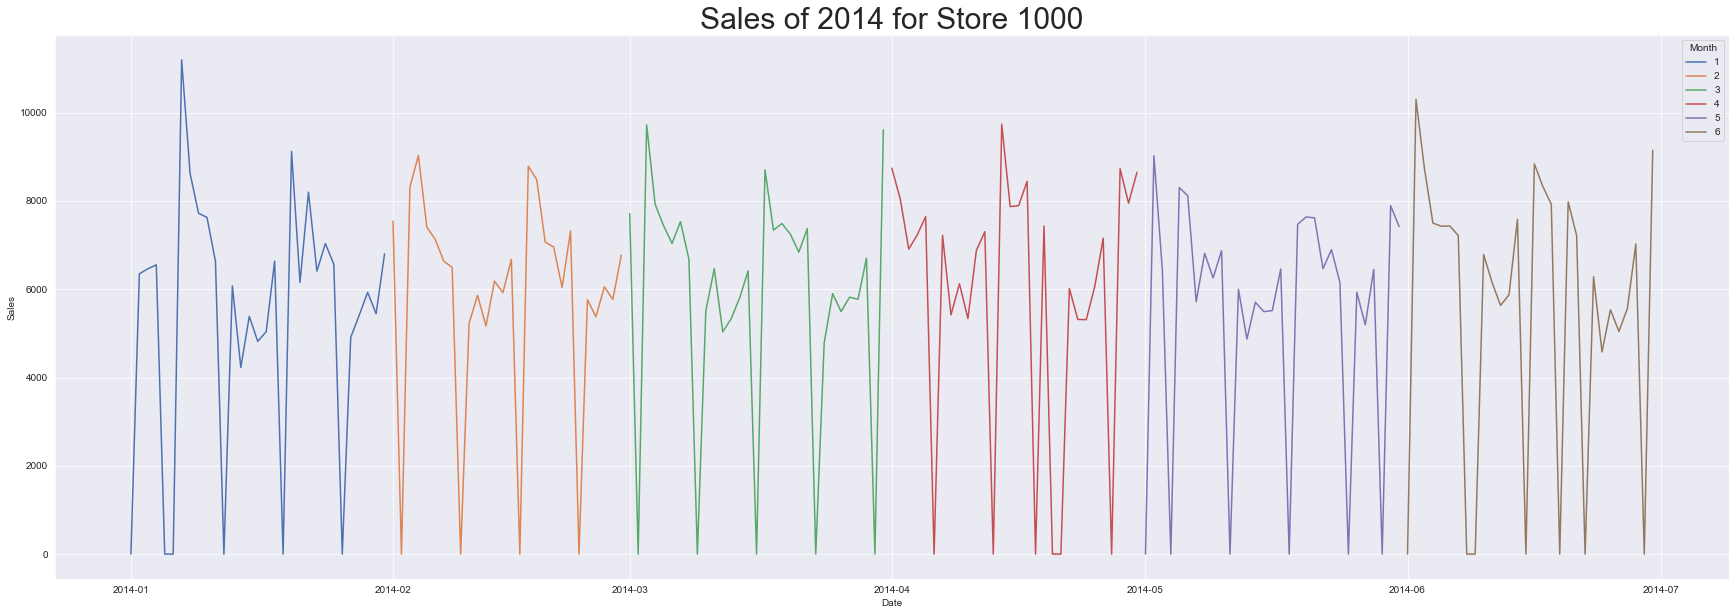

In [8]:
fig = plt.figure(figsize=(30, 10))
sns.lineplot(data=sample_store, x='Date', y='Sales', hue='Month', palette='deep')
plt.title("Sales of 2014 for Store 1000", fontsize=30)

# Auto-correlation and Correlation Plot

Autocorrelation plot, tells us the similarity between observations as a function of time lag between them. It is designed to show whether the elements of a time series are positively correlated, negatively correlated, or independent of each other. It can range from –1 to 1.

The horizontal axis of an autocorrelation plot shows the size of the lag between the elements of the time series. For example, the autocorrelation with lag 2 is the correlation between the time series elements and the corresponding elements that were observed two time periods earlier.

The kth lag is the time period that happened “k” time points before time i.

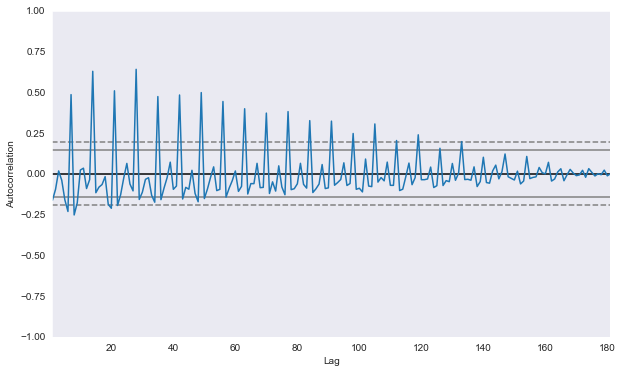

In [9]:
plt.rc("figure", figsize=(10,6))
pd.plotting.autocorrelation_plot(sample_store.Sales);

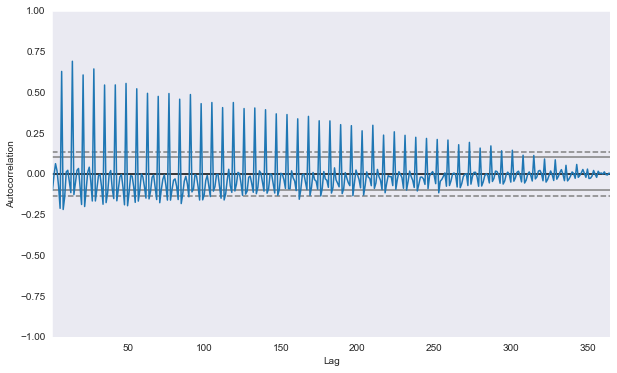

In [10]:
sample_store = train_df.query("Store==1 & Year==2014")
sample_store = sample_store.sort_values(by='Date', ascending=False)
plt.rc("figure", figsize=(10,6))
pd.plotting.autocorrelation_plot(sample_store.Sales);

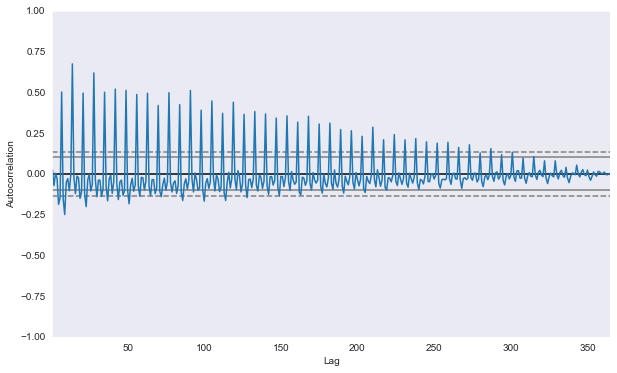

In [ ]:
sample_store = train_df.query("Store==24 & Year==2014")
sample_store = sample_store.sort_values(by='Date', ascending=False)
plt.rc("figure", figsize=(10,6))
pd.plotting.autocorrelation_plot(sample_store.Sales);

# Check if data is Stationary using `Unit Root Test`

In [11]:
adfResult = adfuller(sample_store.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -3.3465857126159846
p-value: 0.012920250161456212


## Removing Stationarity

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

A standard way to remove a trend is by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t). This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next.

In [13]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)



In [14]:
sample_store.Sales.values[:10]

array([2605, 6466, 6463,    0, 6057,    0,    0, 3659, 7959, 9331])

**Seeing the zero's in sales makes me realize that they should be removed. This is mostly from when the store was closed. So in the real world, if the store is closed there won't be any `Sales` for that date. And I don't need to confuse the model with data it won't be seeing during inference. 

I will add a preprocessing step that filters out rows with zero `Sales` and `Open` set to 0 as well

In [ ]:
print(f"Before we had {train_df.shape[0]} rows")
train_df = train_df.query("Sales > 0 & Open == 1")
print(f"Now we have {train_df.shape[0]} rows")

Before we had 1017209 rows
Now we have 844338 rows


Recalculate the Unit Root Tests

ADF Statistic: -4.888016788402952
p-value: 3.6796599572442996e-05


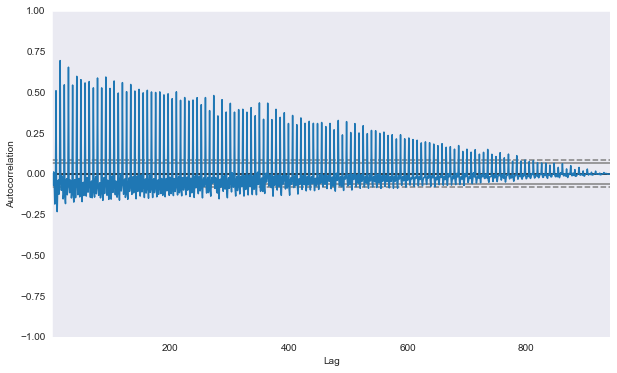

In [15]:
sample_store = train_df.query("Store==24")
sample_store = sample_store.sort_values(by='Date', ascending=False)
plt.rc("figure", figsize=(10,6))
pd.plotting.autocorrelation_plot(sample_store.Sales);

adfResult = adfuller(sample_store.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

Now, I will use the `difference` function on the sample store

In [16]:
deffer = difference(sample_store.Sales.values, 10).values

<AxesSubplot:>

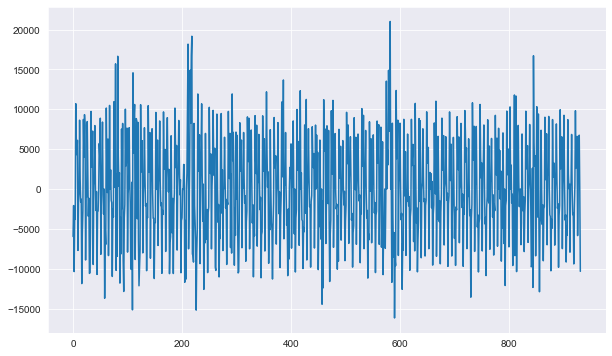

In [17]:
sns.lineplot(x=[*range(len(deffer))], y=deffer)

Our Sales is centered between +ve and -ve 15,000. 

For refernce, I will plot the original Sales

<AxesSubplot:ylabel='Sales'>

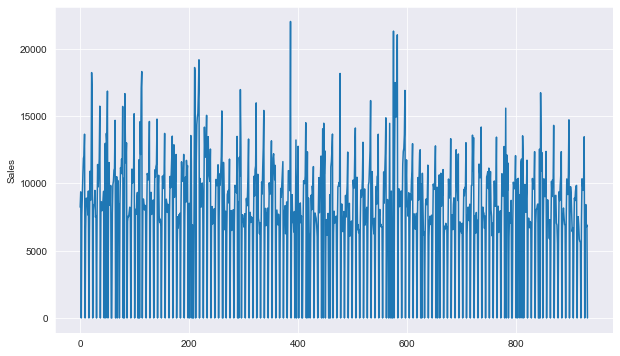

In [18]:
sns.lineplot(x=[*range(len(deffer))], y=sample_store.Sales[10:])